# Setup

In [1]:
import os
import pandas
from benchmarkit import BenchmarKit
from setup import setup_pandas_examples
import time
import numpy
import pyarrow
from pyarrow import csv

small_dataset, medium_dataset, large_dateset = setup_pandas_examples()

data = pandas.read_csv('data/data.csv', parse_dates=['birth_date'])

input_kwargs = {
    "args": [
        (data.head(1000),),
        (data.head(10000),),
        (data.head(100000),),
        (data.head(1000000),),
        (data.head(1000000),),
    ],
    "labels": ["10³", "10⁴", "10⁵", "10⁶"],
}

# Read/Write CSV files

100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


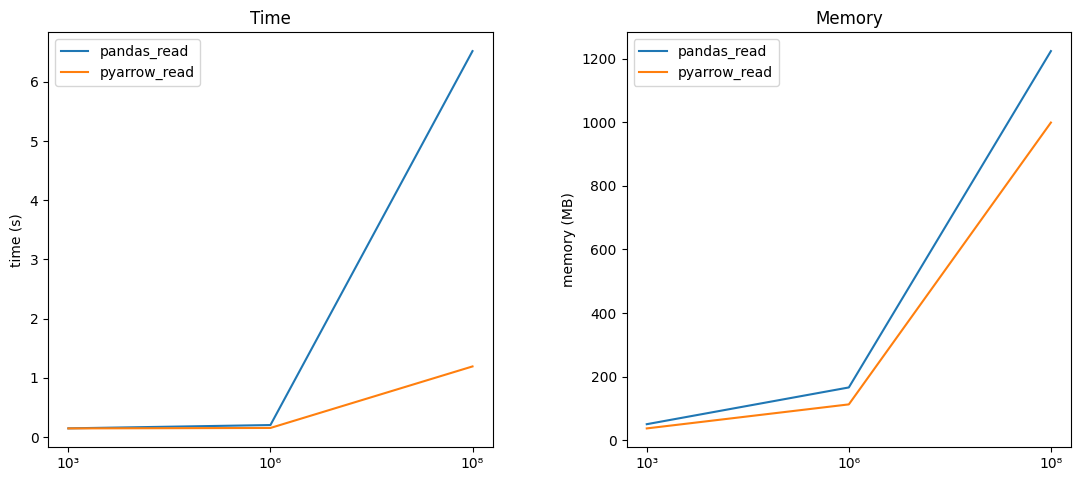

In [43]:
def pandas_read(path):
    pandas.read_csv(path)

def pyarrow_read(path):
    csv.read_csv(path)

benchmarks = BenchmarKit.benchmark(
    funcs=[pandas_read, pyarrow_read],
    args=[
        ("data/small_dataset.csv",),
        ("data/medium_dataset.csv",),
        ("data/large_dataset.csv",),
        ],
    labels=["10³", "10⁶", "10⁸"],
)

benchmarks.plot()

100%|██████████| 6/6 [02:42<00:00, 27.15s/it]


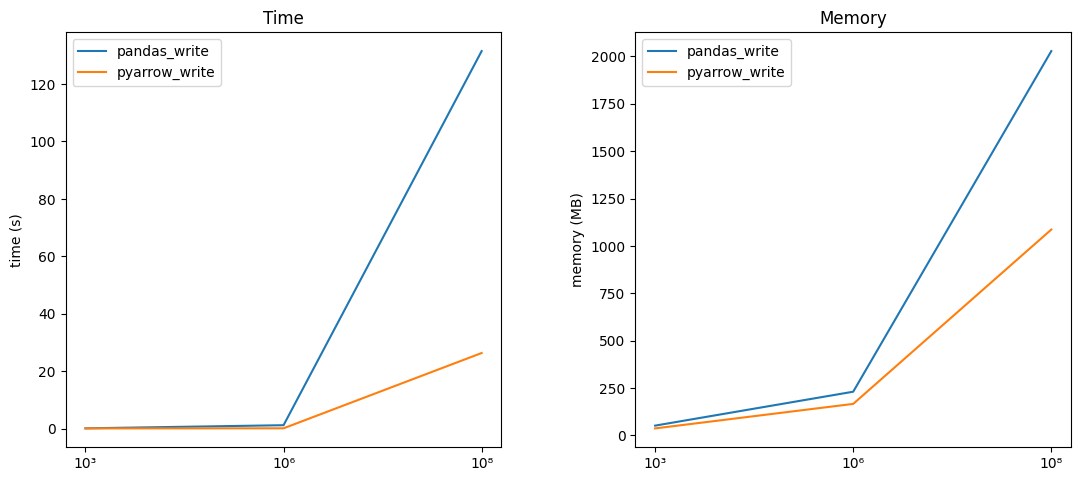

In [44]:
def pandas_write(data: dict):
    pandas.DataFrame.from_dict(data).to_csv("data/pandas_write.csv")

def pyarrow_write(data: dict):
    csv.write_csv(pyarrow.Table.from_pydict(data), "data/pyarrow_write.csv")

benchmarks = BenchmarKit.benchmark(
    funcs=[pandas_write, pyarrow_write],
    args=[
        (small_dataset.to_dict(),),
        (medium_dataset.to_dict(),),
        (large_dateset.to_dict(),),
    ],
    labels=["10³", "10⁶", "10⁸"],)

benchmarks.plot()

# Looping over pandas.DataFrame

`pandas` offers different ways to iterate over `DataFrame` rows: 
1. `DataFrame.iterrows`
2. `DataFrame.itertuples`
3. `DataFrame.iteritems`

While these functions tries to accomplish the same thing. The performance cost is different, especially in the case of a large `DataFrame`. 


100%|██████████| 16/16 [00:35<00:00,  2.21s/it]


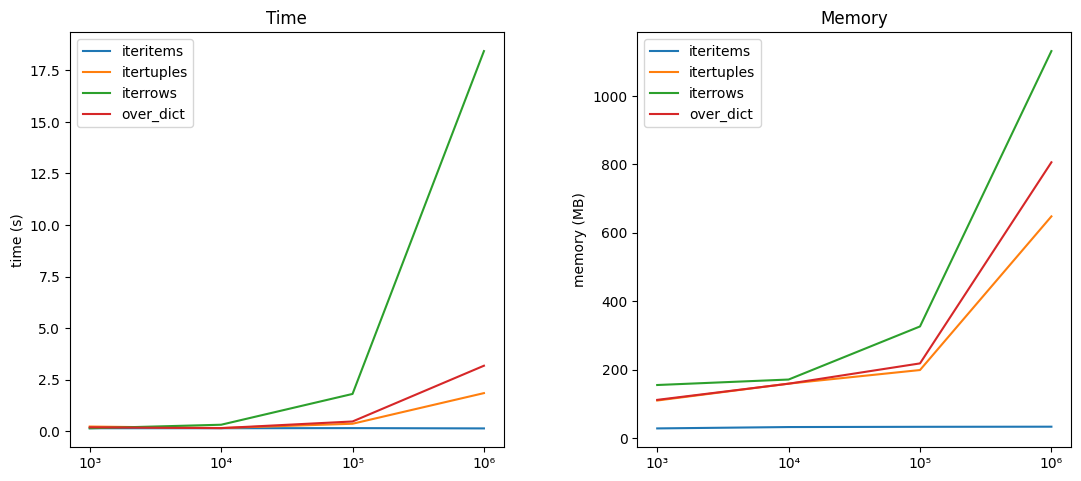

In [4]:

#** functions

def itertuples(data: pandas.DataFrame):
    [_ for _ in data.itertuples()]

def iterrows(data: pandas.DataFrame):
    [_ for _ in data.iterrows()]

def iteritems(data: pandas.DataFrame):
    [_ for _ in data.iteritems()]

def over_dict(data: pandas.DataFrame):
    [_ for _ in data.to_dict("records")]

#** benchmarking 

benchmarks = BenchmarKit.benchmark(
    funcs=[
        iteritems,
        itertuples,
        iterrows,
        over_dict,
    ],
    args=[
        (data.head(1000),),
        (data.head(10000),),
        (data.head(100000),),
        (data.head(1000000),),
    ],
    labels=["10³", "10⁴", "10⁵", "10⁶",],
)

benchmarks.plot()

# Computing a new columns

100%|██████████| 16/16 [00:20<00:00,  1.25s/it]


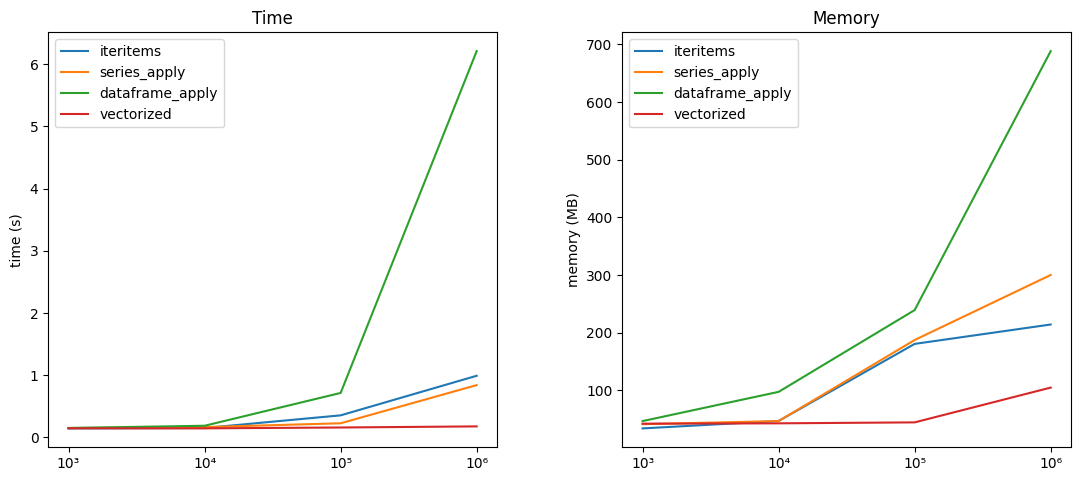

In [41]:
def iteritems(data: pandas.DataFrame):
    pandas.Series([v.year > 1990 for _, v in data['birth_date'].iteritems()])

def series_apply(data: pandas.DataFrame):
    data['birth_date'].apply(lambda x: x.year > 1990)

def dataframe_apply(data: pandas.DataFrame):
    data.apply(lambda x: x.birth_date.year > 1990, axis=1)

def vectorized(data: pandas.DataFrame):
    data['birth_date'].dt.year > 1990

def query(data: pandas.DataFrame):
    data.query('birth_date.dt.year > 1990')

benchmarks = BenchmarKit.benchmark(
    funcs=[
        iteritems,
        series_apply,
        dataframe_apply,
        vectorized,
    ],
    args=[
        (data.head(1000),),
        (data.head(10000),),
        (data.head(100000),),
        (data.head(1000000),),
        # (data.head(10000000),),
        # (data.head(100000000),),
    ],
    labels=["10³", "10⁴", "10⁵", "10⁶"],)

benchmarks.plot()

100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


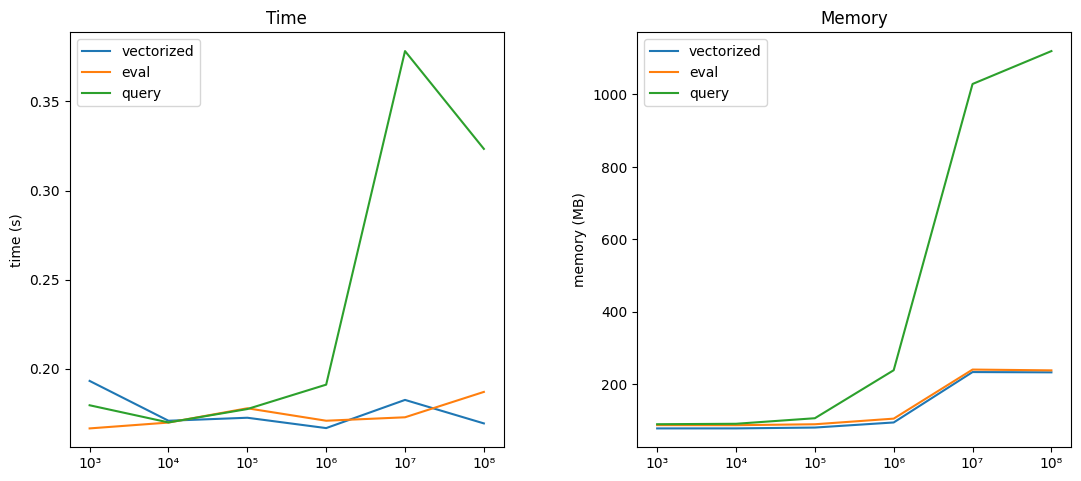

In [4]:
def vectorized(data: pandas.DataFrame):
    data['column_1'] > data['column_2']

def eval(data: pandas.DataFrame):
    pandas.eval('data.column_1 > data.column_2')

def query(data: pandas.DataFrame):
    data.query('column_1 > column_2')

benchmarks = BenchmarKit.benchmark(
    funcs=[
        vectorized,
        eval,
        query,
    ],
    args=[
        (large_dateset.head(1000),),
        (large_dateset.head(10000),),
        (large_dateset.head(100000),),
        (large_dateset.head(1000000),),
        (large_dateset.head(10000000),),
        (large_dateset.head(100000000),),
    ],
    labels=["10³", "10⁴", "10⁵", "10⁶", "10⁷", "10⁸"],)

benchmarks.plot()

# eval() and query()
...

100%|██████████| 18/18 [00:18<00:00,  1.03s/it]


time  memory
function     run              
vectorized   10³   0.1    40.6
             10⁴   0.1    44.5
             10⁵   0.2   118.5
             10⁶   0.2   360.5
             10⁷   2.6  2334.9
             10⁸   1.4  2689.2
eval         10³   0.1    48.5
             10⁴   0.2    50.5
             10⁵   0.1    76.0
             10⁶   0.2   185.8
             10⁷   0.2  1350.9
             10⁸   0.2  1314.8
eval_numexpr 10³   0.1    48.7
             10⁴   0.2    51.5
             10⁵   0.2    66.3
             10⁶   0.2   227.0
             10⁷   0.2  1320.5
             10⁸   0.2  1331.3

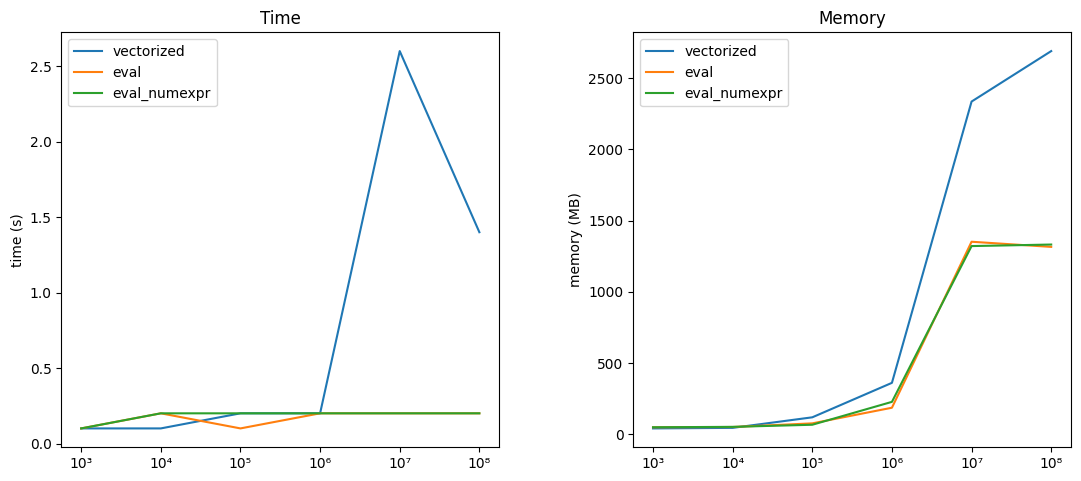

In [35]:
def vectorized(df: pandas.DataFrame):
    (df + df + df + df + df) / (df + df + df + df + df)

def eval(df: pandas.DataFrame):
    pandas.eval("(df + df + df + df + df) / (df + df + df + df + df)")

def eval_numexpr(df: pandas.DataFrame):
    pandas.eval("(df + df + df + df + df) / (df + df + df + df + df)", engine="numexpr")

def query(df: pandas.DataFrame):
    df.query("df.mean()")


benchmarks = BenchmarKit.benchmark(
    funcs=[
        vectorized,
        eval,
        eval_numexpr
    ],
    args=[
        (large_dateset.head(1000),),
        (large_dateset.head(10000),),
        (large_dateset.head(100000),),
        (large_dateset.head(1000000),),
        (large_dateset.head(10000000),),
        (large_dateset.head(100000000),),
    ],
    labels=["10³", "10⁴", "10⁵", "10⁶", "10⁷", "10⁸"],
    precision=1)

benchmarks.plot()
benchmarks.table()

In [5]:
benchmarks.table()

time       memory
function   run                       
vectorized 10³  0.193053    78.312500
           10⁴  0.170681    78.380208
           10⁵  0.172366    80.671875
           10⁶  0.166555    94.729167
           10⁷  0.182383   233.812500
           10⁸  0.169185   233.072917
eval       10³  0.166375    87.375000
           10⁴  0.169658    87.192708
           10⁵  0.177682    89.755208
           10⁶  0.170691   105.296875
           10⁷  0.172623   240.723958
           10⁸  0.186878   238.515625
query      10³  0.179376    89.885417
           10⁴  0.169737    91.098958
           10⁵  0.177248   106.411458
           10⁶  0.190956   238.916667
           10⁷  0.378308  1028.885417
           10⁸  0.323379  1119.677083

# References

* [Enhancing performance (official pandas documentation v1.5)](https://pandas.pydata.org/docs/user_guide/enhancingperf.html)
* [Scaling to large datasets (official pandas documentation v1.5)](https://pandas.pydata.org/docs/user_guide/scale.html)
* [speed up pandas query x10 with dask (Matthew Powers • February 14, 2022)](https://coiled.io/blog/speed-up-pandas-query-10x-with-dask/)
* [How To Make Your Pandas Loop 71803 Times Faster (Benedikt Droste • Aug 23, 2019)](https://towardsdatascience.com/how-to-make-your-pandas-loop-71-803-times-faster-805030df4f06)
